In [1]:
from SyMBac.phase_contrast_drawing import run_simulation, get_trench_segments, draw_scene
from SyMBac.general_drawing import generate_curve_props, gen_cell_props_for_draw, get_space_size, convolve_rescale
import numpy as np
import matplotlib.pyplot as plt
import napari
import pickle


In [2]:
resize_amount = 3
pix_mic_conv = 0.0655 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
sim_length = 50

In [3]:
cell_timeseries_properties_file = open("../docs/source/docs_notebooks/cell_timeseries_properties.p", "rb")
cell_timeseries_properties = pickle.load(cell_timeseries_properties_file)
cell_timeseries_properties_file.close()

main_segments_file = open("../docs/source/docs_notebooks/main_segments.p", "rb")
main_segments = pickle.load(main_segments_file)
main_segments_file.close()

In [4]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

do_transformation = True
offset = 30
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Scene Draw::   0%|          | 0/998 [00:00<?, ?it/s]

In [26]:
scenes_array = np.array(scenes)

In [78]:
cells = scenes_array[:,0,:,:]*1.5

In [79]:
volume_shape = cells.shape[1:] + (int(cells.max()),)

In [80]:
test_cells = np.round(cells[-1])

In [81]:
centreline = int(cells.max()/2)

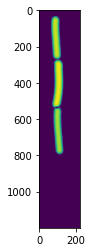

In [82]:
plt.imshow(test_cells)

In [83]:
cells_3D = np.zeros(volume_shape)

In [85]:
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness)+centreline - int(np.ceil(thickness/2))

In [86]:
def gen_3D_coords_from_2D(centreline, thickness):
    return np.where(test_cells==thickness) + (generate_deviation_from_CL(centreline, thickness),)

In [87]:
for t in range(int(cells.max()*2)):
    test_coords = gen_3D_coords_from_2D(centreline, t)
    for x, y in zip(test_coords[0], test_coords[1]):
        for z in test_coords[2]:
            cells_3D[x,y,z] = 1

In [92]:
cells_3D.shape

(1200, 223, 37)

In [93]:
from vtk.util import numpy_support
import vtk
import numpy as np

data = cells_3D.reshape(37,223,1200)

# vtkImageData is the vtk image volume type
imdata = vtk.vtkImageData()
# this is where the conversion happens
depthArray = numpy_support.numpy_to_vtk(data.ravel(), deep=True, array_type=vtk.VTK_DOUBLE)

# fill the vtk image data object
imdata.SetDimensions(data.shape)
imdata.SetSpacing([1,1,1])
imdata.SetOrigin([0,0,0])
imdata.GetPointData().SetScalars(depthArray)

# f.ex. save it as mhd file
writer = vtk.vtkMetaImageWriter()
writer.SetFileName("test.mhd")
writer.SetInputData(imdata)
writer.Write()

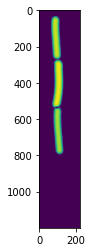

In [94]:
plt.imshow(cells_3D.sum(axis=2))

In [91]:
import napari

viewer = napari.view_image(cells_3D)
napari.run()  # start the event loop and show viewer